Guillaume Chaslot (guillaume.chaslot@data.gouv.fr)

# Tax Law Simplifier

Tax law is more than 200,000 lines long and opaque.
We believe that with this tool, we can make it less than 100 lines, transparent, and 99% similar to the existing.

### How it works:

1. Define your concepts and budget
2. Automatic tuning helps you tune your reform to match the current legislation
3. From the biggest discrepencies, improve your concepts
4. Repeat until you reach a legislation that is as close as the current as you like, but much simpler

### Beta version:

For this test, we only take a population of people from all ages, who have 0 to 5 children, no salary, married, veuf, paces, divorces or celibataires, and simulate the aides sociales.

In [68]:
from compare_simulators import CalculatorComparator
from population_simulator import CerfaPopulationSimulator
from utils import show_histogram
from utils import percent_diff
from utils import scatter_plot

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

# Load population data

The population data is simulated for now, see population_simulator.py for details. Just do it.

In [69]:
comp = CalculatorComparator()
comp.load_results_from_json('1aj-1bj-f-2000')

revdisp = comp.get_variable_from_openfisca('revdisp')

# Extracts concepts of interest

You can add concepts here if you like. The input population is in the CERFA declaration des revenus format.

In [80]:
population = []
original_index = []

def cas_improbable(case):
    # It is highly unlikely to have enfants a charge above 64 so we remove those cases
    if (int(case['0DA']) <= 1950 or ('0DB' in case and int(case['0DA'] <= 1950))) and 'F' in case and int(case['F']) > 0:
        return True
    return False

for i in range(0, len(comp.testcases)):
    case = comp.testcases[i]
    if case.get('1AJ', 0) < 1 and case.get('1BJ', 0) < 1 and not cas_improbable(case):
        original_index.append(i)
        new_family = {}
        new_family['taxable_income'] =  case.get('1AJ', 0)
        new_family['revdisp'] = revdisp[i]

        if 'F' in case:
            if case['F'] == 1:
                new_family['enfant_unique'] = 1
            if case['F'] >= 2:
                new_family['enfants_deux_ou_plus'] = 1
            if case['F'] > 2:
                new_family['nb_enfants_au_dessus_de_2'] = case['F'] - 2
            new_family['nb_enfants'] = case['F']

        if 'O' in case or 'M' in case:
            new_family['two_people'] = 1                

        one_declarant_above_24 = False
        both_declarant_parent_below_24 = 'F' in case

        if '0DA' in case:
            age_1 = 2014 - case['0DA']
            new_family['age-dec1'] = age_1
#             if age <= 24 and 'F' in case:
#                 new_family['declarant parent <= 24 ans'] = 1
            if age_1  >= 24:
                one_declarant_above_24 = True
                both_declarant_parent_below_24 = False
#                 new_family['declarant > 24 ans'] = 1
            if age_1  > 64:
                new_family['declarant > 64 ans'] = 1
                new_family['declarants > 64 ans'] = 1

        age_2 = 0            
        if '0DB' in case:
            age_2 = 2014 - case['0DB']
            new_family['age-dec2'] = age_2
            if age_2  >= 24:
                one_declarant_above_24 = True
                both_declarant_parent_below_24 = False

#                 new_family['codeclarant > 24 ans'] = 1
            if age_2  > 64:
                new_family['declarants > 64 ans'] = new_family.get('declarants > 64 ans', 0) + 1
                new_family['codeclarant > 64 ans'] = 1

        if age_1 >= 24 and age_2 >= 24:
            new_family['both > 24 ans'] = 1

        if both_declarant_parent_below_24:
            new_family['both_declarant_parent_below_24'] = True
            
        if one_declarant_above_24:
            new_family['one_declarant_above_24'] = True

        if 'F' in case and ('C' in case or 'D' in case or 'V' in case):
            new_family['parent_isolé'] = True
            
        if 'F' in case and ('M' in case or 'O' in case):
            new_family['parents_en_couple'] = True

        population.append(new_family)

print 'Number of family: ' + repr(len(population))

total_people = 0
for family in comp.testcases:
    total_people += 1
    if '0DB' in family and family['0DB'] == 1:
        total_people += 1
    if 'F' in family:
        total_people += family['F']

# We assume that there are 2000000 people with RSA
echantillon =  float(total_people) / 2000000
print 'Echantillon of ' + repr(total_people) + ' people, in percent of french population for similar revenu: ' + repr(echantillon)


Number of family: 742
Echantillon of 2863 people, in percent of french population for similar revenu: 0.0014315


# Plots Revenu disponible before reform

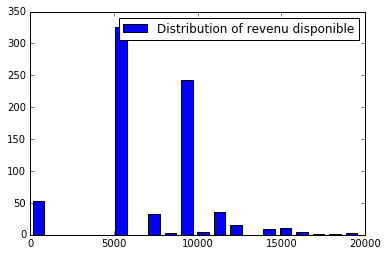

In [71]:
revdisp_when_no_salary = list(family['revdisp'] for family in population)

show_histogram(revdisp_when_no_salary, 'Distribution of revenu disponible')

# Define your reform here !

Give all the concepts you care about either as:

* <strong> boolean parameters</strong> add value if present (e.g., one_declarant_above_24)


* <strong> linear parameters </strong> add value proportional to the parameters (e.g., nb_enfants)


* <strong> segmentation parameters </strong> are segmented by the algorithm into several boolean parameters (e.g., age_declarant_principal might be broken down automatically by the algo into 0-25 / 25-64 / 65+)

In [72]:
from reformators import Excalibur

sword = Excalibur(population, 'revdisp', 'taxable_income', echantillon=echantillon)
simulated_reform = sword.suggest_reform(
                           boolean_parameters = ['one_declarant_above_24',
                                                 'codeclarant > 64 ans',
                                                 'declarant > 64 ans',
                                                 'both_declarant_parent_below_24',
                                                 'two_people'],
                           linear_parameters = ['nb_enfants'],
                           barem_parameters = [],
                           save=0)

Population size = 742
['one_declarant_above_24', 'codeclarant > 64 ans', 'declarant > 64 ans', 'both_declarant_parent_below_24', 'two_people', 'nb_enfants']
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=688055, Fri Sep 23 11:16:18 2016)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.569779978938720e+13 1.0e+00 9.26e+03  9e+03  9e+03 0:0.0
    2     18 8.104669751097796e+12 1.2e+00 9.11e+03  8e+03  1e+04 0:0.0
    3     27 6.526081221976559e+12 1.4e+00 8.32e+03  7e+03  1e+04 0:0.1
Average error per person = 2788 saving 1420 millions
Average error per person = 2312 saving 83 millions
Average error per person = 255 saving 26 millions
Average error per person = 247 saving 18 millions
Average error per person = 234 saving 8 millions
Average error per person = 233 saving 0 millions
  100    900 2.507568508790015e+10 1.3e+02 7.71e+01  3e+00  2e+02 0:2.4
Average error per person = 196 saving 0 millions
Average error per person = 205 saving 0 mi

# Plots revenu disponible after reform

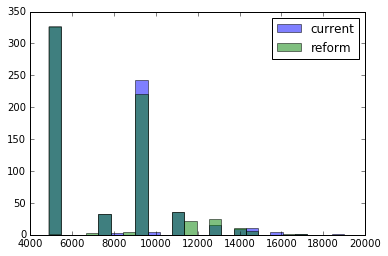

In [73]:
xmin = 4900
xmax = 19000
nb_buckets = 25

bins = np.linspace(xmin, xmax, nb_buckets)

plt.hist(revdisp_when_no_salary, bins, alpha=0.5, label='current')
plt.hist(simulated_reform, bins, alpha=0.5, label='reform')
plt.legend(loc='upper right')
plt.show()

# Distribution of the changes in revenu in euros

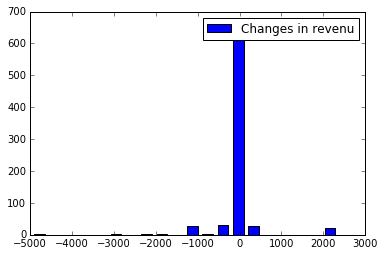

In [74]:
difference = list(simulated_reform[i] - revdisp_when_no_salary[i] for i in range(len(simulated_reform)))

show_histogram(difference, 'Changes in revenu')

# Distribution of the change in revenu in percentage

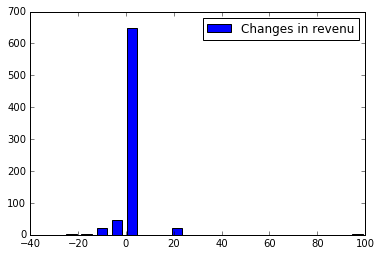

In [75]:
percentage_difference = list(100 * percent_diff(simulated_reform[i], revdisp_when_no_salary[i]) for i in range(len(simulated_reform)))

show_histogram(percentage_difference, 'Changes in revenu')

# Change as a function of the number of children

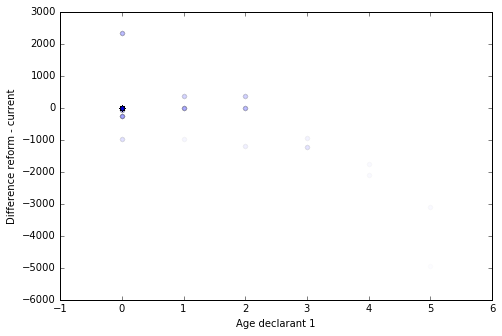

In [76]:
nb_children = list((population[i].get('nb_enfants', 0)  for i in range(len(population)))) 

scatter_plot(nb_children, difference, 'Age declarant 1', 'Difference reform - current', alpha=0.01)

# Change as a function of the age of declarant 1

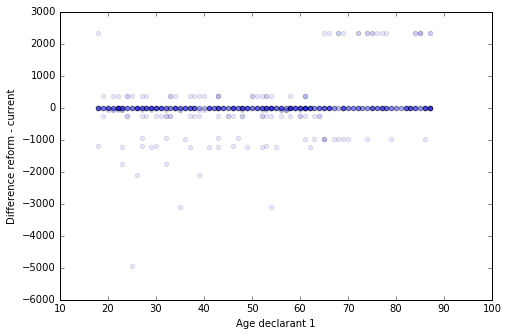

In [77]:
age_dec1 = list((population[i].get('age-dec1', 0)  for i in range(len(population)))) 

scatter_plot(age_dec1, difference, 'Age declarant 1', 'Difference reform - current', alpha=0.1)

# Cases that 

This is the heart of this tool: by seeing the worse cases, you can discover when the current legislation is smarter than yours, and improve it further.

In [78]:
original_population = []
original_revdisp = []
for i in range(0, len(population)):
    original_population.append(comp.testcases[original_index[i]])
    original_revdisp.append(revdisp[original_index[i]])

order = sorted(range(len(simulated_reform)), key=lambda k: -abs(simulated_reform[k] - revdisp_when_no_salary[k]))

for i in order:
    print 'Case ' + repr(original_population[i]) + ' Current =' + repr(int(revdisp_when_no_salary[i])) + ' Reform = ' + repr(int(simulated_reform[i]))

Case {u'C': 1, u'year': 2014, u'F': 5, u'0DA': 1989, u'1AJ': 0} Current =19173 Reform = 14216
Case {u'F': 5, u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1994, u'0DA': 1960, u'1AJ': 0} Current =19673 Reform = 16559
Case {u'F': 5, u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1988, u'0DA': 1979, u'1AJ': 0} Current =19673 Reform = 16559
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1995, u'0DA': 1996, u'1AJ': 0} Current =0 Reform = 2342
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1975, u'0DA': 1927, u'1AJ': 0} Current =9513 Reform = 11855
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1990, u'0DA': 1942, u'1AJ': 0} Current =9513 Reform = 11855
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1951, u'0DA': 1939, u'1AJ': 0} Current =9513 Reform = 11855
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1966, u'0DA': 1929, u'1AJ': 0} Current =9513 Reform = 11855
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1977, u'0DA': 1939, u'1AJ': 0} Current =9513 Reform = 11855
Case {u'M': 1, u'y

# Best compromise simplicity / matching current legislation:

In [81]:
sword = Excalibur(population,'revdisp', 'taxable_income', echantillon=echantillon)
res = sword.suggest_reform(boolean_parameters=[
                            'enfant_unique',
                            'enfants_deux_ou_plus',
                            'nb_enfants_au_dessus_de_2',
                            'one_declarant_above_24',
                            'declarant > 64 ans',
                            'codeclarant > 64 ans',
                            'two_people',
                           ],
                          save=0)

Population size = 742
['enfant_unique', 'enfants_deux_ou_plus', 'enfants_fam_nombreuse', 'one_declarant_above_24', 'declarant > 64 ans', 'codeclarant > 64 ans', 'two_people']
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=695537, Fri Sep 23 11:19:28 2016)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 8.444273758136905e+12 1.0e+00 9.73e+03  9e+03  1e+04 0:0.0
    2     18 3.374530567813071e+13 1.2e+00 8.76e+03  8e+03  9e+03 0:0.0
    3     27 2.705276790610542e+13 1.3e+00 8.20e+03  7e+03  9e+03 0:0.1
Average error per person = 8516 saving -1293 millions
Average error per person = 1558 saving 550 millions
Average error per person = 1642 saving 106 millions
Average error per person = 1198 saving 22 millions
Average error per person = 1070 saving 277 millions
Average error per person = 1044 saving 119 millions
Average error per person = 975 saving 295 millions
Average error per person = 866 saving 45 millions
Average error per person = 352 sa

In [62]:
original_population = []
original_revdisp = []
for i in range(0, len(population)):
    original_population.append(comp.testcases[original_index[i]])
    original_revdisp.append(revdisp[original_index[i]])

order = sorted(range(len(simulated_reform)), key=lambda k: -abs(simulated_reform[k] - revdisp_when_no_salary[k]))

for i in order:
    print 'Case ' + repr(original_population[i]) + ' Current =' + repr(int(revdisp_when_no_salary[i])) + ' Reform = ' + repr(int(simulated_reform[i]))

Case {u'C': 1, u'year': 2014, u'F': 5, u'0DA': 1989, u'1AJ': 0} Current =19173 Reform = 14216
Case {u'F': 5, u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1994, u'0DA': 1960, u'1AJ': 0} Current =19673 Reform = 16559
Case {u'F': 5, u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1988, u'0DA': 1979, u'1AJ': 0} Current =19673 Reform = 16559
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1995, u'0DA': 1996, u'1AJ': 0} Current =0 Reform = 2342
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1975, u'0DA': 1927, u'1AJ': 0} Current =9513 Reform = 11855
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1990, u'0DA': 1942, u'1AJ': 0} Current =9513 Reform = 11855
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1951, u'0DA': 1939, u'1AJ': 0} Current =9513 Reform = 11855
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1966, u'0DA': 1929, u'1AJ': 0} Current =9513 Reform = 11855
Case {u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1977, u'0DA': 1939, u'1AJ': 0} Current =9513 Reform = 11855
Case {u'M': 1, u'y